In [1]:
import numpy as np
import struct
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize as opt
from sklearn.metrics import classification_report#这个包是评价报告
from sklearn.model_selection import train_test_split
import math
import copy

In [2]:
def read_labels(enter):
    data = enter.read()
    head = struct.unpack_from('>II', data, 0)
    number = head[1]
    offset = struct.calcsize('>II')
    numString = '>' + str(number) + "B"
    labels = struct.unpack_from(numString, data, offset)
    labels = np.reshape(labels, [number])
    return labels
 

def read_images(enter):
    data = enter.read()
    head = struct.unpack_from('>IIII', data, 0)
    offset = struct.calcsize('>IIII')
    number = head[1]
    width = head[2]
    height = head[3]
    bits = number * width * height
    bitsString = '>' + str(bits) + 'B'
    images = struct.unpack_from(bitsString, data, offset)
    images = np.reshape(images, [number, width *height])
    return images
 
def load_train_data():
    enter = open("train-images-idx3-ubyte",'rb')
    X = read_images(enter)
    enter = open("train-labels-idx1-ubyte",'rb')
    y = read_labels(enter)
#     y = y.reshape((-1,1))
    return X,y

def load_test_data():
    enter = open("t10k-images-idx3-ubyte",'rb')
    X = read_images(enter)
    enter = open("t10k-labels-idx1-ubyte",'rb')
    y = read_labels(enter)
#     y = y.reshape((-1,1))
    return X,y

In [3]:
# X,y = load_data()
X_train,y_train = load_train_data()
X_test,y_test = load_test_data()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)#数据按%80，%20划分
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

In [4]:
def plot_n_image(X,n=100):
    size = int(np.sqrt(X.shape[1]))
    sample_index = np.random.choice(np.arange(X.shape[0]),n)
    sample_images = X[sample_index,:]
    w_h = math.ceil(np.sqrt(n))
    fig,ax_array = plt.subplots(nrows=w_h,ncols=w_h,sharey=True,sharex = True,figsize=(8,8))
    count = 0
    for r in range(w_h):
        for c in range(w_h):
            count+=1
            if count<=n:
                ax_array[r, c].matshow(sample_images[w_h * r + c].reshape((size, size)),
                                       cmap=matplotlib.cm.binary)
                
                plt.xticks(np.array([]))
                plt.yticks(np.array([]))

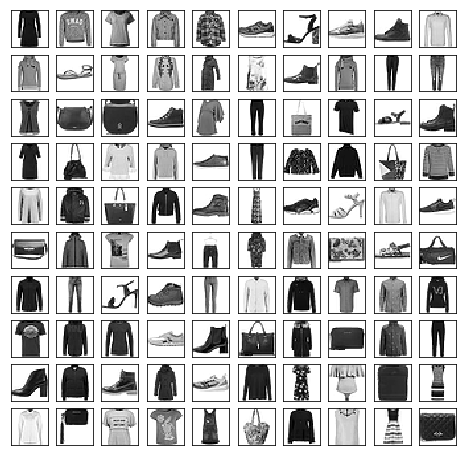

In [5]:
plot_n_image(X_train,100)
plt.savefig("fashion.jpeg")
plt.show()

In [7]:
def sigmoid(x):    
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):    
    return np.maximum(0, x)

def sigmoid_gradient(z):
    return np.multiply(sigmoid(z), (1 - sigmoid(z)))

In [8]:
input_size = 784
hidden_size = 30
output_size = 10
std = 1e-4
# rand函数根据给定维度生成[0,1)之间的数据，shape(input_size, hidden_size)
W1 = std * np.random.randn(input_size, hidden_size)   #(2,10)
b1 = np.zeros((1, hidden_size))                       #(1,10)
W2 = std * np.random.randn(hidden_size,output_size)   #(10,1)
b2 = np.zeros((1, output_size))                       #(1,1)

params = {}
params["W1"] = W1
params["b1"] = b1
params["W2"] = W2
params["b2"] = b2

def accuracy(y,t):
    predicted_class = np.argmax(y, axis=1)
    return (np.mean(predicted_class == t))

# output
def predict(X,params):
    z1 = np.dot(X,params["W1"]) + params["b1"]              
    a1 = relu(z1)                 
    z2 = np.dot(a1,params["W2"]) + params["b2"]
    exp_z2 = np.exp(z2)
    a2 = exp_z2 / np.sum(exp_z2, axis=1, keepdims=True) 
    return a2


def computeLoss(y,t): # y->predict value t->true value
    delta = 1e-5
    num_examples = y.shape[0]
    correct_logprobs = -np.log(y[range(num_examples),t] + delta)
    loss = np.mean(correct_logprobs)  
    return loss

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
 
    batch_size = y.shape[0]
    delta = 1e-5
    return -np.sum(np.log(y[np.arange(batch_size), t] + delta)) / batch_size

In [9]:
def forward_propagation(params,X):
    z1 = np.dot(X,params["W1"]) + params["b1"]              
    a1 = relu(z1)                 
    z2 = np.dot(a1,params["W2"]) + params["b2"]     
    exp_z2 = np.exp(z2)
    a2 = exp_z2 / np.sum(exp_z2, axis=1, keepdims=True) 
    return z1,a1,z2,a2

z1,a1,z2,a2= forward_propagation(params,X_train)

In [10]:
computeLoss(a2,y_train),cross_entropy_error(a2,y_train)

(2.302472682756849, 2.302472682756849)

In [11]:
a2.shape,y_train.shape

((60000, 10), (60000,))

In [12]:
def train(X,y,X_t,y_t,params,iterations,alpha = 7.5e-4):
    best_acc = -1
    best_t_acc = -1
    best_params = {}
    loss_history = []
    acc_history = []
    acc_t_history = []
    loss_t_history = []
    num_examples = X.shape[0]
    for i in range(iterations):
        z1,a1,z2,a2 = forward_propagation(params,X)
        tz1,ta1,tz2,ta2 = forward_propagation(params,X_t)
        loss = computeLoss(a2,y)
        loss_t = computeLoss(ta2,y_t)
        
        acc = accuracy(a2,y)
        acc_t = accuracy(ta2,y_t)
        
        if i % 10 == 0:
            loss_history.append(loss)
            acc_history.append(acc)

            loss_t_history.append(loss_t)
            acc_t_history.append(acc_t)

            print("iteration %d: train_loss %f acc %f" % (i, loss,acc))

#         if i % 100 == 0:
#             alpha = alpha*0.95
            
        # 存储最佳准确率
        if acc > best_acc:
            best_acc = acc 
            best_params = copy.deepcopy(params)  # 深复制 指向的不是同一内存空间，对params做任何修改，best的值都不会变化
            
        if acc_t > best_t_acc:
            best_t_acc = acc_t

        dz2 = a2
        dz2[range(num_examples),y] -= 1
        dz2/= num_examples
        dW2 = np.dot(a1.T, dz2)
        db2 = np.sum(dz2, axis=0, keepdims=True)
        dz1 = np.dot(dz2,params["W2"].T)
        dz1[z1 <= 0] = 0
        dW = np.dot(X.T,dz1)
        db = np.sum(dz1, axis=0, keepdims=True)

        params["W1"] += -alpha * dW
        params["b1"] += -alpha * db
        params["W2"] += -alpha * dW2
        params["b2"] += -alpha * db2
        
    return {   
        'loss_history': loss_history,   
        'acc_history': acc_history,   
        'loss_t_history': loss_t_history,   
        'acc_t_history': acc_t_history, 
        "params": best_params,
        "best_acc":best_acc,
        "best_t_acc":best_t_acc,
    } 

In [13]:
stats = train(X_train,y_train,X_test,y_test,params,1000)

iteration 0: train_loss 2.302473 acc 0.103350
iteration 10: train_loss 2.300359 acc 0.198400
iteration 20: train_loss 2.240772 acc 0.151717
iteration 30: train_loss 1.879481 acc 0.308817
iteration 40: train_loss 1.506340 acc 0.420233
iteration 50: train_loss 1.307526 acc 0.534667
iteration 60: train_loss 1.163131 acc 0.576517
iteration 70: train_loss 1.146739 acc 0.549433
iteration 80: train_loss 1.095207 acc 0.586567
iteration 90: train_loss 1.013370 acc 0.611883
iteration 100: train_loss 0.964910 acc 0.625200
iteration 110: train_loss 0.926549 acc 0.633083
iteration 120: train_loss 0.895219 acc 0.637583
iteration 130: train_loss 0.868529 acc 0.642217
iteration 140: train_loss 0.845072 acc 0.649633
iteration 150: train_loss 0.824162 acc 0.658800
iteration 160: train_loss 0.804859 acc 0.669300
iteration 170: train_loss 0.786783 acc 0.680050
iteration 180: train_loss 0.769973 acc 0.689183
iteration 190: train_loss 0.754165 acc 0.697750
iteration 200: train_loss 0.739481 acc 0.705733
ite

In [14]:
stats["best_acc"],stats["best_t_acc"]

(0.8488166666666667, 0.8333)

In [15]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.subplots_adjust(wspace =0, hspace =0.3)

<Figure size 720x576 with 0 Axes>

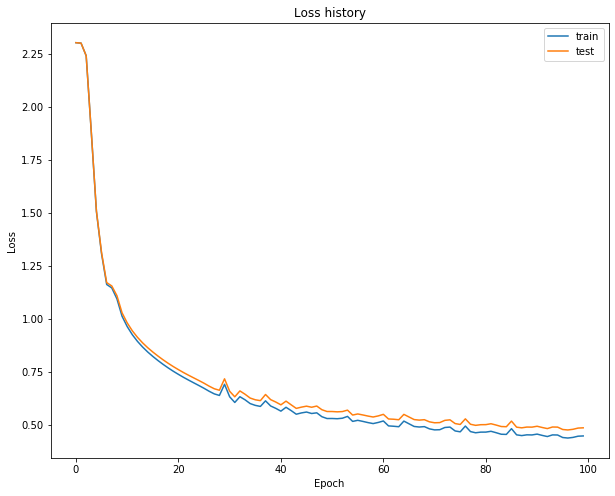

In [16]:
plt.plot(stats['loss_history'], label='train')
plt.plot(stats['loss_t_history'], label='test')
plt.title('Loss history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("loss.jpeg")
plt.show()

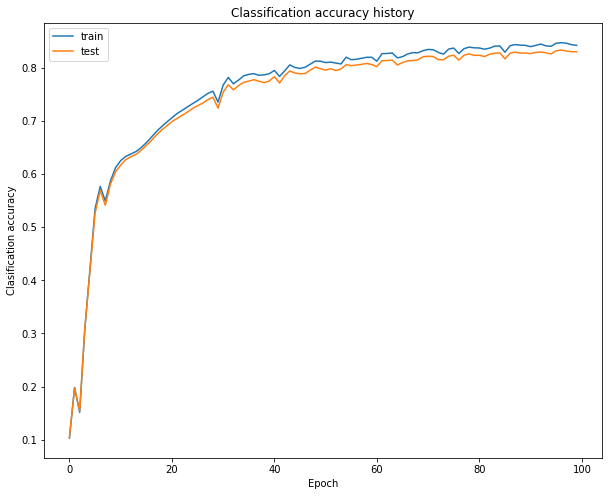

In [17]:
plt.plot(stats['acc_history'], label='train')
plt.plot(stats['acc_t_history'], label='test')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.savefig("acc.jpeg")

In [24]:
predicted_class = np.argmax(predict(X_train,params), axis=1)
print(classification_report(y_train,predicted_class))

              precision    recall  f1-score   support

           0       0.77      0.86      0.81      6000
           1       0.96      0.96      0.96      6000
           2       0.68      0.84      0.75      6000
           3       0.84      0.87      0.86      6000
           4       0.73      0.74      0.74      6000
           5       0.95      0.89      0.92      6000
           6       0.75      0.45      0.56      6000
           7       0.90      0.93      0.91      6000
           8       0.94      0.95      0.94      6000
           9       0.92      0.94      0.93      6000

    accuracy                           0.84     60000
   macro avg       0.84      0.84      0.84     60000
weighted avg       0.84      0.84      0.84     60000



In [25]:
predicted_class = np.argmax(predict(X_test,params), axis=1)
print(classification_report(y_test,predicted_class))

              precision    recall  f1-score   support

           0       0.77      0.83      0.80      1000
           1       0.96      0.95      0.96      1000
           2       0.65      0.82      0.72      1000
           3       0.82      0.86      0.84      1000
           4       0.72      0.72      0.72      1000
           5       0.95      0.88      0.91      1000
           6       0.71      0.43      0.54      1000
           7       0.89      0.92      0.91      1000
           8       0.93      0.94      0.94      1000
           9       0.91      0.94      0.92      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



In [22]:
np.random.randn()

-0.17696015811669347